In [12]:
# Source: https://www.marineregions.org/gazetteer.php?p=details&id=4288
uri = "https://geo.vliz.be/geoserver/wfs?request=getfeature&service=wfs&version=1.1.0&typename=MarineRegions:iho&outputformat=json&filter=%3CPropertyIsEqualTo%3E%3CPropertyName%3Eid%3C%2FPropertyName%3E%3CLiteral%3E26%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E"
token = "ngd7cFvOqHXOUynG1I@UfasgwvEgJYb2NqPWQR_Vt0f37qCZzHG3WBtRKpoo1UU7"

In [2]:
import sys
!{sys.executable} -m pip install pandas python-dateutil sentinelsat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 1.2 MB/s eta 0:00:00
  Using cached geomet-1.0.0-py3-none-any.whl (28 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 1.8 MB/s eta 0:00:0092.3 MB/s eta 0:00:01
  Using cached html2text-2020.1.16-py3-none-any.whl (32 kB)

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [82]:
from typing import Dict
import datetime
import pandas as pd
from dateutil.parser import parse
from sentinelsat import SentinelAPI, geojson_to_wkt
import json
import pickle
import numpy as np

In [90]:
scihub_username = ""
scihub_password = ""

In [26]:
def search(
    wkt: str,
    datetime_start: datetime.datetime,
    datetime_end: datetime.datetime,
    platformname: str = "Sentinel-2",
    timedelta: int = 1,
    verbose: bool = False,
) -> Dict:
    """
    Search Sentinel Hub
    """
    api = SentinelAPI(scihub_username, scihub_password)
    
    results = api.query(
        wkt,
        date=(datetime_start, datetime_end),
        platformname=platformname
    )
    
    return results

    items = [item[1] for item in list(results.items()) if item[1]["beginposition"] <= datetime_start and item[1]["endposition"] >= datetime_start]
    row = items_to_row(items)
    
    if len(items):
        print(f"{platformname} acquisition found for {datetime_start} {datetime_end}")
    else:
        print(f"{platformname} acquisition not found for {datetime_start} {datetime_end}")
    
    
    return row


In [9]:
import geopandas as gpd

In [10]:
data_frame = gpd.read_file(uri)
data_frame

,name,id,longitude,latitude,min_x,min_y,max_x,max_y,area,mrgid,geometry
0,Gulf of Mexico,26,-90.379585,24.942316,-98.053922,17.406808,-80.433041,31.464844,1566759,4288,"MULTIPOLYGON (((-80.79515 24.81051, -80.85158 ..."


<AxesSubplot: >

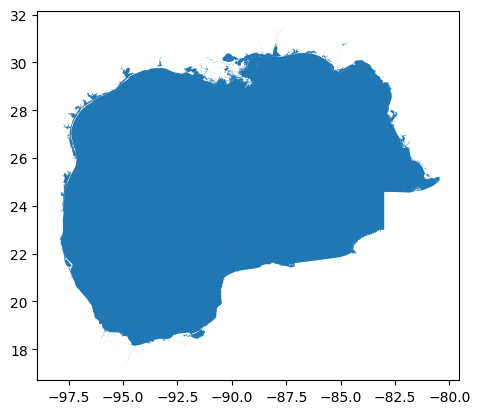

In [11]:
data_frame.plot()

In [13]:
geometry = data_frame.iloc[0].geometry
geometry

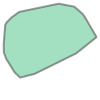

In [23]:
geometry.convex_hull

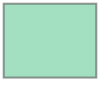

In [21]:
geometry.envelope

## Search for 2022 Sentinel 2 data

In [89]:
results = search(geometry.convex_hull.wkt, datetime_start=datetime.datetime(2022, 1, 1), datetime_end=datetime.datetime(2022, 12, 31))

## Filter in Level-2A processed data

In [63]:
scenes = [result[1] for result in results.items() if result[1]["processinglevel"] == "Level-2A"]

In [64]:
scenes[0]

{'title': 'S2B_MSIL2A_20221230T162659_N0509_R040_T16QDM_20221230T192003',
 'link': "https://apihub.copernicus.eu/apihub/odata/v1/Products('f22da1e4-f9ab-4785-abf8-7ea709b39b2b')/$value",
 'link_alternative': "https://apihub.copernicus.eu/apihub/odata/v1/Products('f22da1e4-f9ab-4785-abf8-7ea709b39b2b')/",
 'link_icon': "https://apihub.copernicus.eu/apihub/odata/v1/Products('f22da1e4-f9ab-4785-abf8-7ea709b39b2b')/Products('Quicklook')/$value",
 'summary': 'Date: 2022-12-30T16:26:59.024Z, Instrument: MSI, Satellite: Sentinel-2, Size: 889.96 MB',
 'ondemand': 'false',
 'generationdate': datetime.datetime(2022, 12, 30, 19, 20, 3),
 'beginposition': datetime.datetime(2022, 12, 30, 16, 26, 59, 24000),
 'endposition': datetime.datetime(2022, 12, 30, 16, 26, 59, 24000),
 'ingestiondate': datetime.datetime(2022, 12, 30, 22, 3, 26, 444000),
 'orbitnumber': 30382,
 'relativeorbitnumber': 40,
 'illuminationazimuthangle': 157.334061898319,
 'illuminationzenithangle': 50.4942897411148,
 'vegetationpe

In [80]:
def get_size(item):
    size = item["size"]
    size, unit = size.split(" ")
    
    size = float(size)
    
    if unit == "GB":
        size = size * 1000

    return size

In [83]:
sizes = [get_size(scene) for scene in scenes]

In [86]:
np.sum(sizes)

20041817.18

In [87]:
len(sizes)

30214

In [88]:
np.sum(sizes) / len(sizes)

663.3288270338254